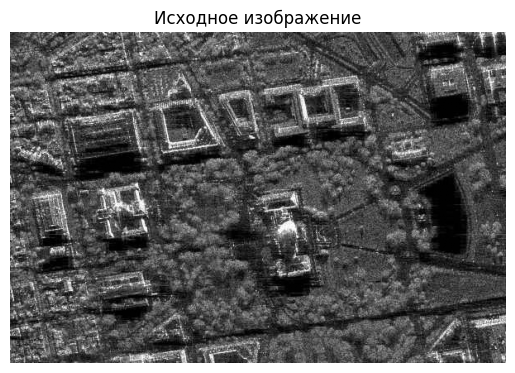

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

# Правильное имя файла
img_color = cv2.imread('sar_1_gray.jpg')   # ← вот здесь
if img_color is None:
    raise FileNotFoundError("Файл sar_1_gray.jpg не найден! Проверь имя и расширение.")

img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

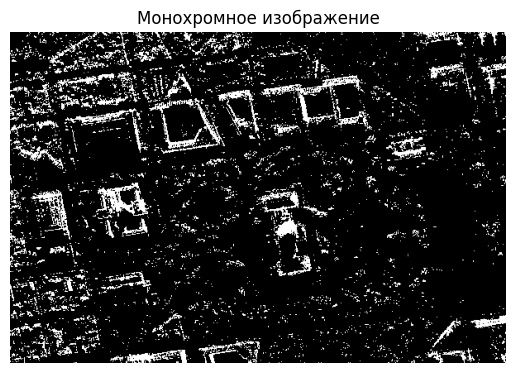

In [2]:
# Простая бинаризация порогом 127
_, monochrom = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

# Сохраняем как текст
with open('sar_1_gray_monochrom.txt', 'w') as f:
    for row in monochrom:
        f.write(' '.join(map(str, row)) + '\n')

plt.imshow(monochrom, cmap='gray')
plt.title('Монохромное изображение')
plt.axis('off')
plt.show()

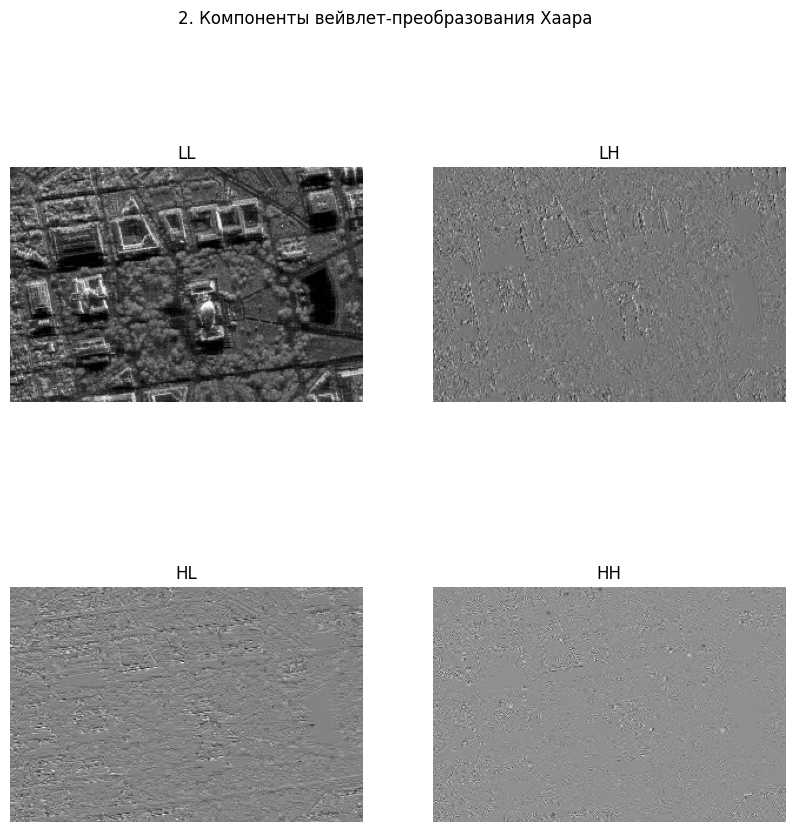

In [3]:
def haar_wavelet_transform(img):
    img = img.astype(np.float32)
    h, w = img.shape
    out = np.zeros((h, w), dtype=np.float32)
    
    # По строкам
    for i in range(h):
        for j in range(0, w, 2):
            a = img[i, j]
            if j + 1 < w:
                b = img[i, j + 1]
                out[i, j//2]         = (a + b) / 2
                out[i, j//2 + w//2]  = (a - b) / 2
            else:
                out[i, j//2] = a
    
    result = np.zeros((h, w), dtype=np.float32)
    
    # По столбцам
    for j in range(w):
        for i in range(0, h, 2):
            a = out[i, j]
            if i + 1 < h:
                b = out[i + 1, j]
                result[i//2, j]       = (a + b) / 2
                result[i//2 + h//2, j]= (a - b) / 2
            else:
                result[i//2, j] = a
                
    ll = result[:h//2, :w//2]
    lh = result[:h//2, w//2:]
    hl = result[h//2:, :w//2]
    hh = result[h//2:, w//2:]
    
    return ll, lh, hl, hh

ll, lh, hl, hh = haar_wavelet_transform(img_gray)

# Визуализация
plt.figure(figsize=(10,10))
for i, (name, comp) in enumerate([('LL', ll), ('LH', lh), ('HL', hl), ('HH', hh)], 1):
    plt.subplot(2,2,i)
    plt.imshow(comp, cmap='gray')
    plt.title(name)
    plt.axis('off')
plt.suptitle('2. Компоненты вейвлет-преобразования Хаара')
plt.show()

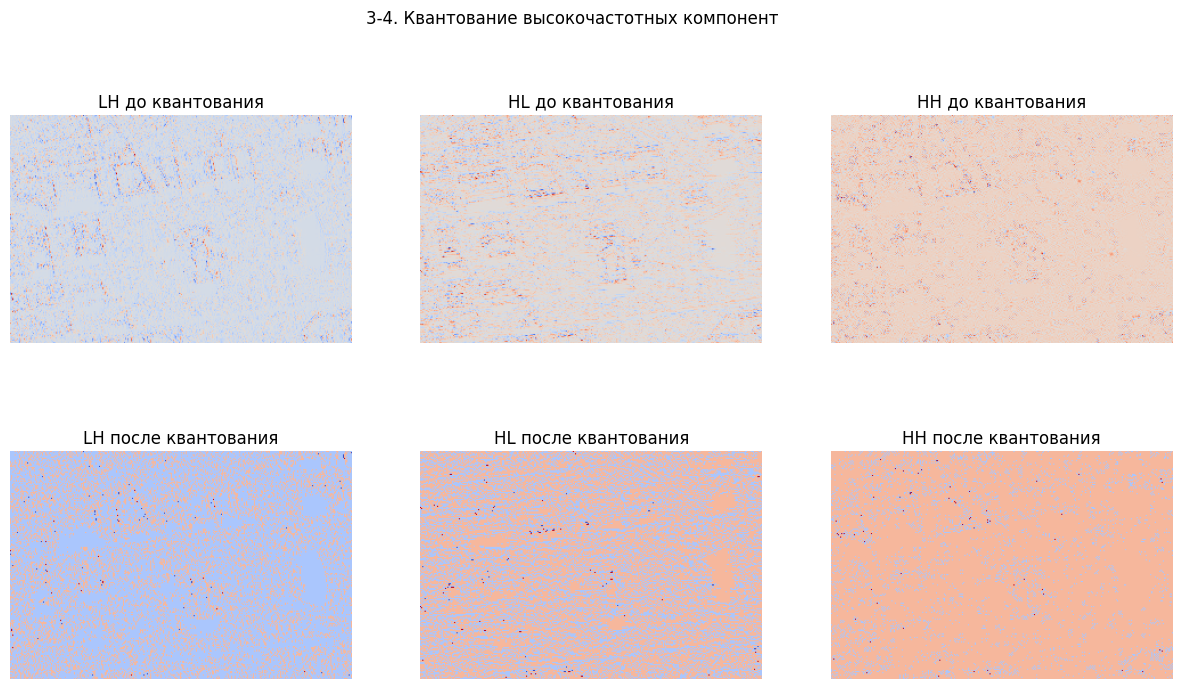

In [4]:
def quantize(component, levels=4):
    min_val = component.min()
    max_val = component.max()
    step = (max_val - min_val) / (levels - 1) if max_val > min_val else 1
    quantized = np.round((component - min_val) / step).astype(np.int16)
    return quantized, min_val, step

def dequantize(q, min_val, step):
    return min_val + q * step

lh_q, lh_min, lh_step = quantize(lh, 4)
hl_q, hl_min, hl_step = quantize(hl, 4)
hh_q, hh_min, hh_step = quantize(hh, 4)

# До и после
plt.figure(figsize=(15,8))
for i, (name, orig, q) in enumerate([('LH', lh, lh_q), ('HL', hl, hl_q), ('HH', hh, hh_q)], 1):
    plt.subplot(2,3,i)
    plt.imshow(orig, cmap='coolwarm')
    plt.title(f'{name} до квантования')
    plt.axis('off')
    
    plt.subplot(2,3,i+3)
    plt.imshow(dequantize(q, eval(f'{name.lower()}_min'), eval(f'{name.lower()}_step')), cmap='coolwarm')
    plt.title(f'{name} после квантования')
    plt.axis('off')
plt.suptitle('3-4. Квантование высокочастотных компонент')
plt.show()

In [5]:
def rle_encode(arr):
    flat = arr.flatten()
    encoded = []
    prev = flat[0]
    count = 1
    for val in flat[1:]:
        if val == prev:
            count += 1
        else:
            encoded.append((int(prev), count))
            prev = val
            count = 1
    encoded.append((int(prev), count))
    return encoded

lh_rle = rle_encode(lh_q)
hl_rle = rle_encode(hl_q)
hh_rle = rle_encode(hh_q)

# Сохранение
with open('sar_1_gray_haar.txt', 'w') as f:
    np.savetxt(f, ll.astype(int), fmt='%d')
    f.write('\n')
    for name, rle in [('LH', lh_rle), ('HL', hl_rle), ('HH', hh_rle)]:
        f.write(f'=== {name} ===\n')
        for val, cnt in rle:
            f.write(f'{val} {cnt}\n')
        f.write('\n')

print("5. Файл sar_1_gray_haar.txt успешно сохранён")

5. Файл sar_1_gray_haar.txt успешно сохранён


In [6]:
size_mono = os.path.getsize('sar_1_gray_monochrom.txt')
size_haar = os.path.getsize('sar_1_gray_haar.txt')

print(f"Размер монохромного текстового файла: {size_mono:,} байт")
print(f"Размер после Хаара + RLE:             {size_haar:,} байт")
print(f"Коэффициент сжатия: {size_mono / size_haar:.2f} раз")

Размер монохромного текстового файла: 529,912 байт
Размер после Хаара + RLE:             457,649 байт
Коэффициент сжатия: 1.16 раз
